In [9]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

/home/abhinav-kompella/miniforge3/envs/dl_3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abhinav-kompella/miniforge3/envs/dl_3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/abhinav-kompella/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.09MB/s]


In [10]:
for name, layer in model.named_modules():
    print(name, ":", layer)

 : ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)

In [1]:
import argparse
import torch
import torch.backends.cudnn as cudnn
from torchvision import models
import sys
import os
# sys.path.append(os.path.abspath('../simCLR'))

# from model import YourModelClass
from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
from models.resnet_simclr import ResNetSimCLR
from simclr import SimCLR

/home/abhinav-kompella/miniforge3/envs/dl_3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = ResNetSimCLR(base_model='resnet18', out_dim=128)
device = "cpu"
checkpoint = torch.load('/home/abhinav-kompella/Documents/CV/cvProject/src/SimCLR/checkpoint_1000.pth(1).tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])

/home/abhinav-kompella/miniforge3/envs/dl_3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abhinav-kompella/miniforge3/envs/dl_3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [3]:
import numpy as np

model.eval()

feature_maps = []
gradients = []

def forward_hook(module, input, output):
    feature_maps.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# Hook into the last convolutional layer 
target_layer = model.backbone.layer1
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import random

class SimCLRTransform:
    """Generate 2 augmented views of an image."""
    def __init__(self):
        self.base_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # brightness, contrast, saturation, hue
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=3),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean for CIFAR-10
                                 (0.2023, 0.1994, 0.2010))  # std for CIFAR-10
        ])

    def __call__(self, x):
        xi = self.base_transform(x)
        xj = self.base_transform(x)
        return xi, xj

# Load CIFAR-10
transform = SimCLRTransform()

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataset_2 = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=None
)

(x1, x2), _ = dataset[0]
x1_og, _ = dataset_2[0]
# ((x1, x2), _), = dataset[0:1] 

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

x1 = x1.unsqueeze(0).to(device)  # Add batch dimension
x2 = x2.unsqueeze(0).to(device)

feature_maps.clear()
gradients.clear()

embedding1 = model(x1)
embedding2 = model(x2)

# Define similarity target (cosine similarity between embeddings)
similarity = F.cosine_similarity(embedding1, embedding2)

# Backward pass to compute gradients
model.zero_grad()
similarity.backward() 

# Grad-CAM
# Feature maps and gradients have been collected
fm   = feature_maps[0]  # [1,256,2,2]  if layer3
grad = gradients[0]     # [1,256,2,2]

weights = grad.mean(dim=[2,3], keepdim=True)      # [1,256,1,1]
cam     = (weights * fm).sum(dim=1, keepdim=True)  # [1,1,2,2]


In [9]:
print(len(feature_maps))

2


In [13]:
print(cam.shape)
cam     = F.relu(cam)
cam     = F.interpolate(cam, size=(32,32),
                        mode='bilinear', align_corners=False)

torch.Size([1, 1, 8, 8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.221393..2.3396237].


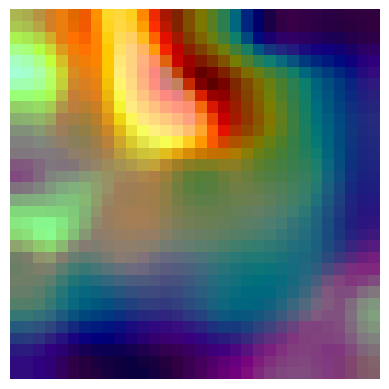

In [14]:
cam_np  = cam.squeeze().cpu().detach().numpy()

cam_np  = (cam_np - cam_np.min()) / (cam_np.max() - cam_np.min())  # Normalize
# 7. Plot
plt.imshow(x1.squeeze().permute(1, 2, 0).cpu())  # input image
plt.imshow(cam.view(32,32).detach().numpy(), cmap='jet', alpha=0.5)            # overlay CAM
plt.axis('off')
plt.show()

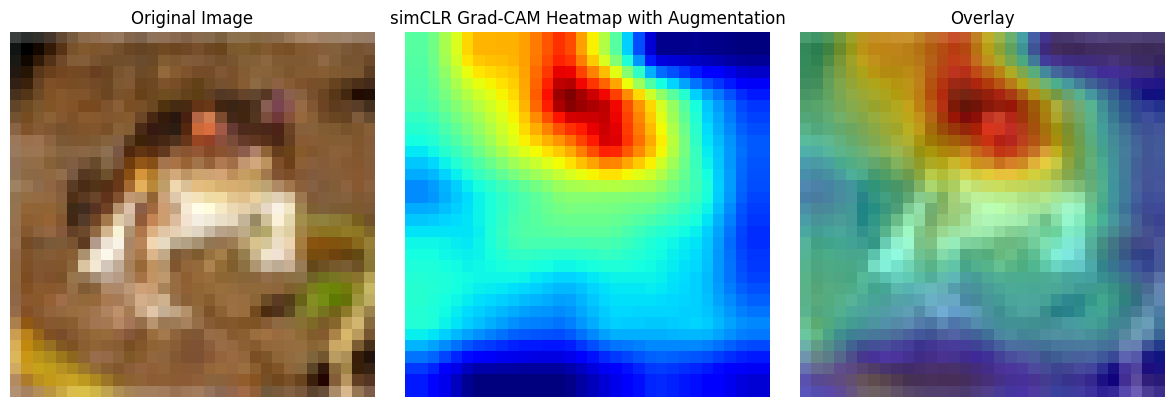

In [20]:
plt.figure(figsize=(12, 4))

# 1. Original image
plt.subplot(1, 3, 1)
plt.imshow(x1_og)
plt.title("Original Image")
plt.axis('off')

# 2. CAM heatmap alone
plt.subplot(1, 3, 2)
plt.imshow(cam.view(32,32).detach().numpy(), cmap='jet')
plt.title("simCLR Grad-CAM Heatmap with Augmentation")
plt.axis('off')

# 3. Overlay
plt.subplot(1, 3, 3)
plt.imshow(x1_og)
plt.imshow(cam.view(32,32).detach().numpy(), cmap='jet', alpha=0.5)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.753146..1.0431099].


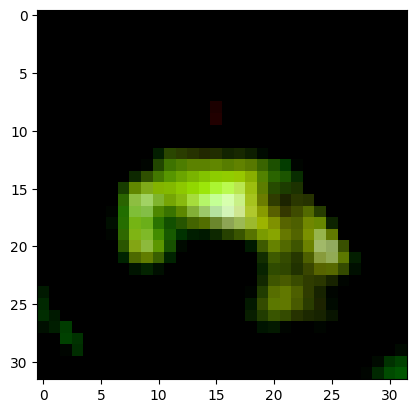

In [15]:
plt.imshow(x2.squeeze().permute(1, 2, 0).cpu())  # input image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.221393..2.3396237].


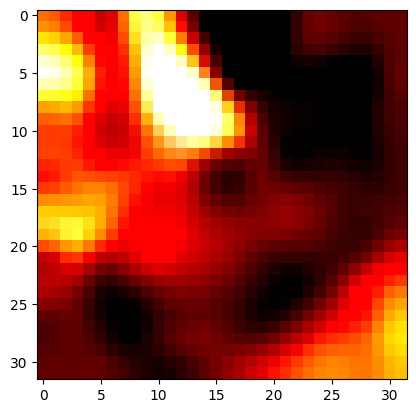

In [16]:
plt.imshow(x1.squeeze().permute(1, 2, 0).cpu())  # input image


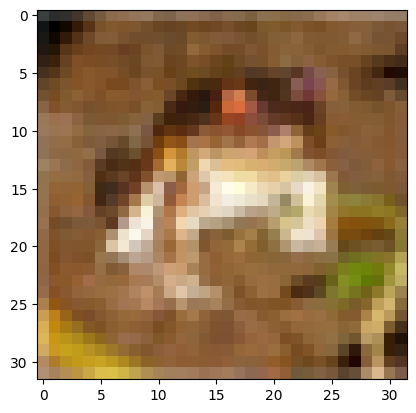

In [18]:
# show x_og image

plt.imshow(x1_og)  # input image